In [15]:
!pip install -q scikit-lego
!pip install catboost
!pip install xgboost
!pip install tensorflow_decision_forests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import HistGradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor,RandomForestRegressor,BaggingRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tensorflow_probability as tfp

import os
import sys
import math
import time
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import tensorflow_probability as tfp

from sklearn.base import clone
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from scipy.spatial.distance import squareform
from sklego.linear_model import LADRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import median_absolute_error, roc_auc_score, roc_curve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 101.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing ins

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c playground-series-s3e25
!unzip playground-series-s3e25.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  0% 0.00/562k [00:00<?, ?B/s]
100% 562k/562k [00:00<00:00, 30.0MB/s]
Archive:  playground-series-s3e25.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
data = pd.read_csv('train.csv', index_col='id')
data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [10]:
print(data.isnull().any())
print(f'Duplicates?: {data.duplicated().any()}')
#data.drop_duplicates(inplace=True)

allelectrons_Total       False
density_Total            False
allelectrons_Average     False
val_e_Average            False
atomicweight_Average     False
ionenergy_Average        False
el_neg_chi_Average       False
R_vdw_element_Average    False
R_cov_element_Average    False
zaratio_Average          False
density_Average          False
Hardness                 False
dtype: bool
Duplicates?: False


array([[<Axes: title={'center': 'allelectrons_Total'}>,
        <Axes: title={'center': 'density_Total'}>,
        <Axes: title={'center': 'allelectrons_Average'}>],
       [<Axes: title={'center': 'val_e_Average'}>,
        <Axes: title={'center': 'atomicweight_Average'}>,
        <Axes: title={'center': 'ionenergy_Average'}>],
       [<Axes: title={'center': 'el_neg_chi_Average'}>,
        <Axes: title={'center': 'R_vdw_element_Average'}>,
        <Axes: title={'center': 'R_cov_element_Average'}>],
       [<Axes: title={'center': 'zaratio_Average'}>,
        <Axes: title={'center': 'density_Average'}>,
        <Axes: title={'center': 'Hardness'}>]], dtype=object)

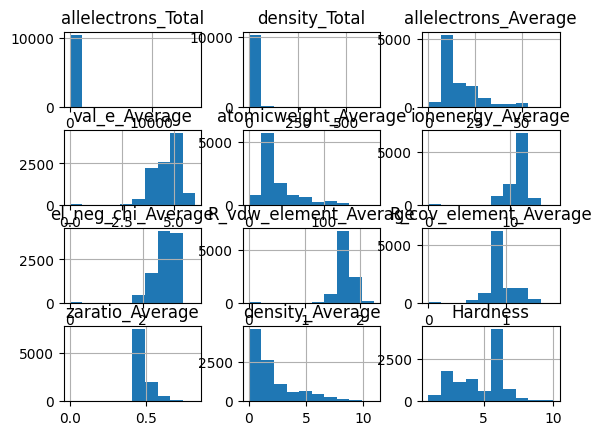

In [11]:
data.hist()

In [12]:
data.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


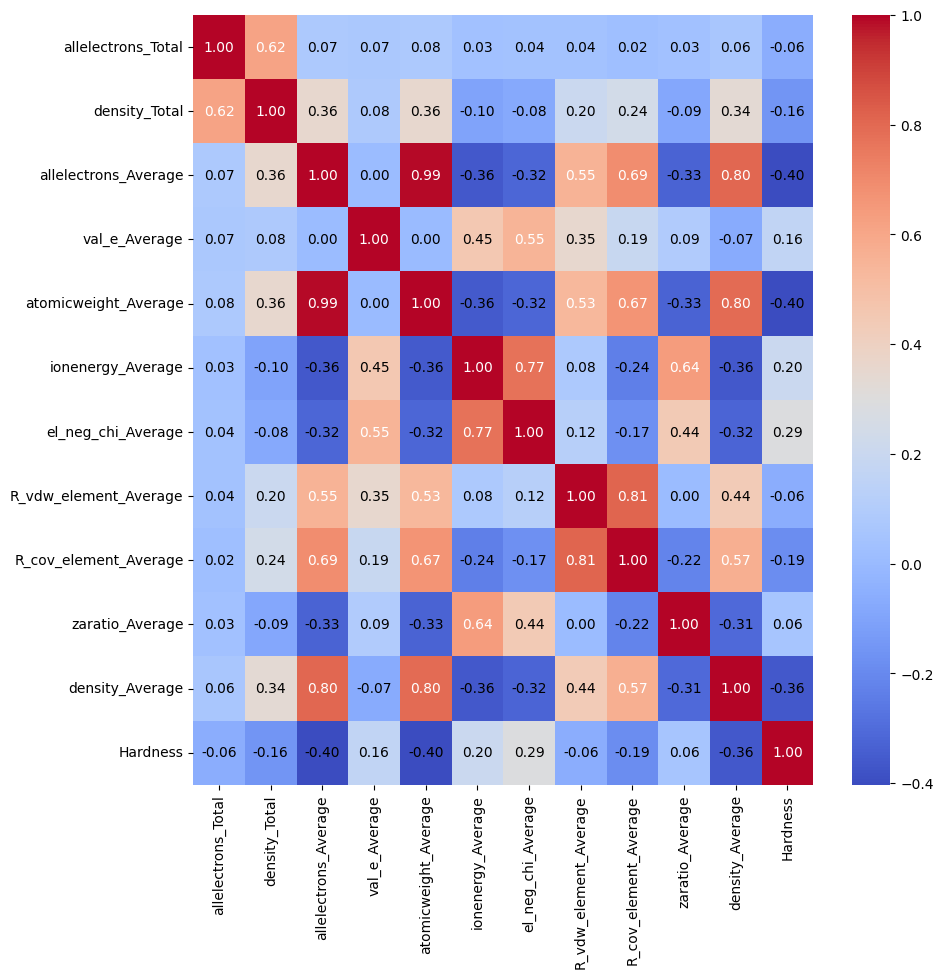

In [26]:
def highlight_vals(val):
    if val > 0.5:
        return 'white'
    else:
        return 'black'

corr = data.corr()

plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

# Apply custom styling for annotations
for text in heatmap.texts:
    text.set_color(highlight_vals(float(text.get_text())))

plt.show()

In [ ]:
#data.drop(['allelectrons_Total', 'allelectrons_Average'], axis=1, inplace=True)
#data.drop(['atomicweight_Average', 'density_Average'], axis=1, inplace=True)
data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


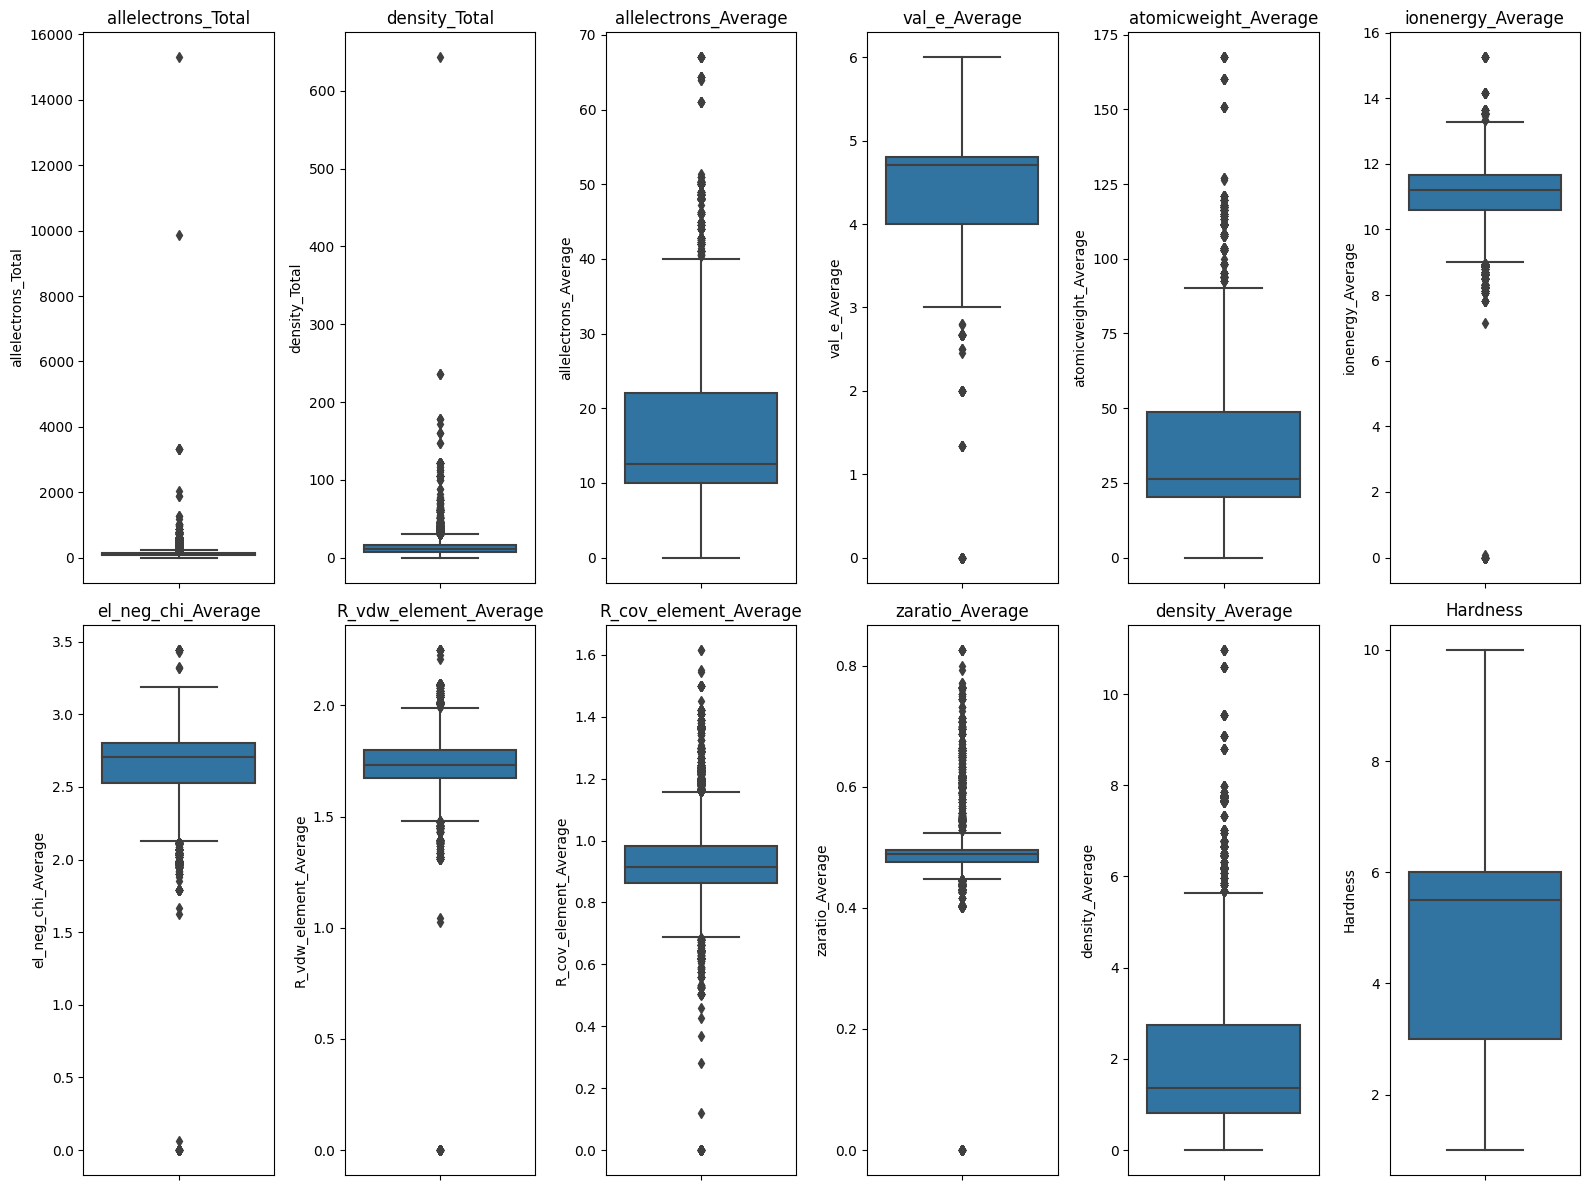

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

# Loop through each column in the data
for i, column in enumerate(data.columns):
    # Create a subplot for each column
    # The arguments are (nrows, ncols, index)
    plt.subplot(2, 6, i+1)
    sns.boxplot(y=data[column])
    plt.title(column)

plt.tight_layout()  # Adjusts the layout
plt.show()

In [ ]:
from scipy.stats.mstats import winsorize

#winsorize(data.allelectrons_Total, limits=0.025, inplace=True)
for i in data.columns.to_list():
  if (i!='Hardness'):
    winsorize(data[i], limits=0.1, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1]
y = data.iloc[:, -1]
y.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back into pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
X_train_scaled.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,,
2124,0.000000,0.000000,0.044776,1.000000,0.044344,1.000000,1.000000,0.000000,0.221426,0.281574,0.000000
394,0.117318,0.404336,0.626866,0.000000,0.708815,0.000000,0.005133,1.000000,1.000000,0.204427,0.918257
3101,0.301676,0.408302,0.139925,0.292969,0.124771,0.645574,0.503722,0.405063,0.426523,0.360536,0.267308
1737,0.603352,0.820918,1.000000,0.260417,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
561,0.491620,0.871745,0.373134,0.520833,0.389778,0.442645,0.553131,0.510549,0.476304,0.196449,0.295372


# Predicting

### 1 approach

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = model.predict(X_test_scaled)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')


MAE: 1.173802870884816
MSE: 2.12245650261222
RMSE: 1.4568653000920229
R-squared: 0.21913165886508834


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    print(f'{name} trained.')

    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate model
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'R2': r2_score(y_test, y_pred)
    }

# Output results
for name, metrics in results.items():
    print(f'Results for {name}:')
    for metric, value in metrics.items():
        print(f'    {metric}: {value:.4f}')

# Hyperparameter tuning for Random Forest
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_clf = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_squared_error')
rf_clf.fit(X_train_scaled, y_train)

# Output best parameters and model
print(f'Best parameters for Random Forest: {rf_clf.best_params_}')
best_rf_model = rf_clf.best_estimator_

# Evaluate the best Random Forest model
best_rf_y_pred = best_rf_model.predict(X_test_scaled)
print(f'Random Forest - MAE: {mean_absolute_error(y_test, best_rf_y_pred)}')
print(f'Random Forest - MSE: {mean_squared_error(y_test, best_rf_y_pred)}')
print(f'Random Forest - RMSE: {mean_squared_error(y_test, best_rf_y_pred, squared=False)}')
print(f'Random Forest - R2: {r2_score(y_test, best_rf_y_pred)}')


LinearRegression trained.
Ridge trained.
Lasso trained.
DecisionTree trained.
RandomForest trained.
GradientBoosting trained.
SVR trained.


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor trained.
Results for LinearRegression:
    MAE: 1.1738
    MSE: 2.1225
    RMSE: 1.4569
    R2: 0.2191
Results for Ridge:
    MAE: 1.1740
    MSE: 2.1224
    RMSE: 1.4569
    R2: 0.2191
Results for Lasso:
    MAE: 1.4689
    MSE: 2.7183
    RMSE: 1.6487
    R2: -0.0001
Results for DecisionTree:
    MAE: 1.2391
    MSE: 3.0550
    RMSE: 1.7479
    R2: -0.1240
Results for RandomForest:
    MAE: 0.9417
    MSE: 1.6010
    RMSE: 1.2653
    R2: 0.4110
Results for GradientBoosting:
    MAE: 0.9315
    MSE: 1.5163
    RMSE: 1.2314
    R2: 0.4421
Results for SVR:
    MAE: 0.9494
    MSE: 1.7572
    RMSE: 1.3256
    R2: 0.3535
Results for MLPRegressor:
    MAE: 0.9758
    MSE: 1.6667
    RMSE: 1.2910
    R2: 0.3868
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - MAE: 0.93276992609056
Random Forest - MSE: 1.5674636013091352
Random Forest - RMSE: 1.251983866233561
Random Forest - R2: 0.4233178863090016


In [ ]:
import pandas as pd

# Step 1: Load the test data
test_data = pd.read_csv('test.csv')
test_data.drop(['atomicweight_Average', 'density_Average'], axis=1, inplace=True)

# Step 2: Preprocess and scale the test data
# (Assuming that 'id' is the first column and should not be scaled)
test_features = test_data.iloc[:, 1:]  # Exclude 'id' column
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as before

# Step 3: Predict 'Hardness' using the best model
test_predictions = best_rf_model.predict(test_features_scaled)

# Step 4: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'Hardness': test_predictions
})

# Step 5: Save the predictions to a CSV file
submission.to_csv('submission.csv', index=False)

# Step 6: Submit the predictions to Kaggle
# kaggle competitions submit -c playground-series-s3e25 -f submission.csv -m "Message"

ValueError: ignored

### 2 approach

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', device='cuda')

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # You can choose a different scorer
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Find the best parameters and the best estimator
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters found: {best_parameters}')

# You can now evaluate the best_model on your test data and proceed with the predictions

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming the scaler has been previously fitted on the training data
# and best_xgb_model is the best model obtained from GridSearchCV

# Step 1: Load the test data
test_data = pd.read_csv('test.csv')

# Optional: If you need to drop certain columns as per preprocessing done during training
#test_data.drop(['atomicweight_Average', 'density_Average'], axis=1, inplace=True)

# Step 2: Preprocess and scale the test data
# (Assuming that 'id' is the first column and should not be scaled)
test_features = test_data.iloc[:, 1:]  # Exclude 'id' column
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as before

# Step 3: Predict 'Hardness' using the best XGBoost model
test_predictions = best_model.predict(test_features_scaled)

# Step 4: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],  # Ensure this is the correct identifier column from your test set
    'Hardness': test_predictions
})

# Step 5: Save the predictions to a CSV file
submission.to_csv('xgb_submission_1.csv', index=False)

# The last step is to submit the predictions to Kaggle using the command line interface
# The command to submit to Kaggle would be run in your terminal, not in Python.
# Example command:
# kaggle competitions submit -c playground-series-s3e25 -f xgb_submission.csv -m "XGB Model Predictions"


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, median_absolute_error

# Make sure the training data is loaded and preprocessed (X_train_scaled, y_train)

# Step 1: Define the scorer based on Median Absolute Error
medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

# Step 2: Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Step 3: Initialize the GridSearchCV
xgb_model = XGBRegressor(objective='reg:squarederror', device='cuda')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring=medae_scorer, cv=5, verbose=2)

# Step 4: Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Step 5: Print the best parameters and the best score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best Median Absolute Error: {-grid_search.best_score_}')

# Step 6: Use the best estimator to make predictions on the test set
best_xgb_model = grid_search.best_estimator_

test_data = pd.read_csv('test.csv')

test_features = test_data.iloc[:, 1:]  # Exclude 'id' column
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as before

test_predictions = best_xgb_model.predict(test_features_scaled)

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],  # Replace with the correct 'id' column from your test set
    'Hardness': test_predictions
})

# Save the submission file
submission.to_csv('xgb_submission.csv', index=False)

# Use the following command in your terminal to submit to Kaggle, not in Python
# kaggle competitions submit -c playground-series-s3e25 -f xgb_submission.csv -m "XGBRegressor with GridSearch"


### 3 approach


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

# Assuming you have already split and scaled your data as per your code snippet
# X_train_scaled, X_test_scaled, y_train, y_test are already defined

# Define a parameter grid to search over
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', device='cuda')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV on the training data
# Note: Here we are using the scaled training data
random_search.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds=10)

# Find the best parameters and the best estimator
best_parameters = random_search.best_params_
best_model = random_search.best_estimator_

print(f'Best parameters found: {best_parameters}')

# Feature Importance Analysis
feature_importances = best_model.feature_importances_
print("Feature Importances:", feature_importances)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.58911
[1]	validation_0-rmse:1.53859
[2]	validation_0-rmse:1.49576
[3]	validation_0-rmse:1.45901
[4]	validation_0-rmse:1.42800
[5]	validation_0-rmse:1.39998
[6]	validation_0-rmse:1.37759
[7]	validation_0-rmse:1.35810
[8]	validation_0-rmse:1.34079
[9]	validation_0-rmse:1.32672
[10]	validation_0-rmse:1.31412
[11]	validation_0-rmse:1.30361
[12]	validation_0-rmse:1.29504
[13]	validation_0-rmse:1.28728
[14]	validation_0-rmse:1.28098
[15]	validation_0-rmse:1.27610
[16]	validation_0-rmse:1.27089
[17]	validation_0-rmse:1.26597
[18]	validation_0-rmse:1.26251
[19]	validation_0-rmse:1.25903
[20]	validation_0-rmse:1.25645
[21]	validation_0-rmse:1.25445
[22]	validation_0-rmse:1.25225
[23]	validation_0-rmse:1.25162
[24]	validation_0-rmse:1.24945
[25]	validation_0-rmse:1.24780
[26]	validation_0-rmse:1.24575
[27]	validation_0-rmse:1.24521
[28]	validation_0-rmse:1.24445
[29]	validation_0-rmse:1.24411
[30]	validation_0-rmse:1.24299
[31]	validation_0-rmse:1.24103
[32]	validation_0-

ValueError: ignored

In [ ]:
# Load the test data
test_data = pd.read_csv('test.csv')

# Assuming 'id' is a column in test_data that was not present during training
# Remove 'id' column before scaling
test_features = test_data.drop('id', axis=1)

# Scale the test data using the already fitted scaler
test_data_scaled = scaler.transform(test_features)

# Predict using the best model
test_predictions = best_model.predict(test_data_scaled)

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],  # Keep 'id' for the submission file
    'PredictionTarget': test_predictions
})

# Save the predictions to a CSV file
submission.to_csv('xgb_submission.csv', index=False)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
